In [8]:
import sys
import os
sys.path.insert(0, os.path.abspath('../..'))
from scipy.io import loadmat
from pathlib import Path
import matplotlib.patches as patches
import matplotlib.lines as mlines
import matplotlib.pyplot as plt
from matplotlib import rc
import matplotlib.image as mpimg
import numpy as np
import pandas as pd
# the following import is required for matplotlib < 3.2:
from mpl_toolkits.mplot3d import Axes3D  # noqa
from scipy import stats
from scipy.stats import mannwhitneyu, ttest_rel
from scipy.signal import butter, filtfilt
import mne
import eeg_analysis.funcs4eeg as fe
import re
import imp
import ast
import behavior.func4behav as fb
imp.reload(fe)
imp.reload(fb)

from scipy import signal
from scipy.signal import resample
from scipy.ndimage import zoom

In [26]:
def align_slow(eeg, case, fs):
    if 'endo' in case:
        jump_from, jump_to = int((1.5+1+0.5)*fs), int((1.5+1+1)*fs)
    elif 'exo' in case:
        jump_from, jump_to = int((1.5+0.033*4+0.5)*fs), int((1.5+0.033*4+1)*fs)
    
    for channel in range(len(eeg)):
        eeg[channel] = np.concatenate((eeg[channel][:,:jump_from], eeg[channel][:,jump_to:]), axis=1)
        
    return eeg

case_title = 'endo valid'
case_list = [case_title+' fast', case_title+' slow']
if 'endo' in case_title:
    tmax_list = [1.5+1+0.5+0.05+0.2, 1.5+1+1+0.05+0.2]
else:
    tmax_list = [1.5+0.033*4+0.5+0.05+0.2, 1.5+0.033*4+1+0.05+0.2]

fs = 1200
for i, case in enumerate(case_list):
    tmax = tmax_list[i]
    watch = '1 fixation'
    tmin = 0 # include fix or not?

    highpass = None
    lowpass = None

    sb, sa, rb, ra = fe.pipeline_session_channel(case, watch, tmin, tmax, hipass=highpass, lopass=lowpass, baseline=(0,0), detrend=1)
    
    if 'slow' in case:
        # sham_before_slow = align_slow(sb, case, fs)
        # sham_after_slow = align_slow(sa, case, fs)
        # real_before_slow = align_slow(rb, case, fs)
        # real_after_slow = align_slow(ra, case, fs)

        sham_before_slow = sb
        sham_after_slow = sa
        real_before_slow = rb
        real_after_slow = ra

    else:
        sham_after_fast = sb
        sham_after_fast = sa
        real_before_fast = rb
        real_after_fast = ra

In [27]:
freq_bands = [[4, 8], [8, 12], [12, 30], [30, 50]]
# exclude fixation
endo_fast_interval = [1.5, 1.5+1+0.5+0.05+0.2]
# endo_slow_interval = [1.5, 1.5+1+0.5+0.05+0.2]
endo_slow_interval = [1.5, 1.5+1+1+0.05+0.2]
exo_fast_interval = [1.5, 1.5+0.033*4+0.5+0.05+0.2]
# exo_slow_interval = [1.5, 1.5+0.033*4+0.5+0.05+0.2]
exo_slow_interval = [1.5, 1.5+0.033*4+1+0.05+0.2]

In [4]:
bp_table = np.zeros((4, 32, 4)) # 4 sessions, 32 channels, 4 frequency bands
if 'endo' in case_title:
    intervals = [endo_fast_interval, endo_slow_interval]
else:
    intervals = [exo_fast_interval, exo_slow_interval]
slow_sessions = [sham_before_slow, sham_after_slow, real_before_slow, real_after_slow]
fast_sessions = [sham_after_fast, sham_after_fast, real_before_fast, real_after_fast]
for channel in range(32):
    for k, band in enumerate(freq_bands):
        for i in range(4):
            fast_session = fast_sessions[i][channel]
            slow_session = slow_sessions[i][channel]
            tmp = np.empty(())
            for j, data in enumerate([fast_session, slow_session]):
                interval = intervals[j]
                t_start, t_end = int(interval[0]*fs), int(interval[1]*fs)
                psds, freqs = mne.time_frequency.psd_array_multitaper(data[:,t_start:t_end], fs, fmin=2, fmax=51, verbose=False)
                a = fe.band_power(psds, freqs, band)
                tmp = np.append(tmp, a)
            bp_table[i, channel, k] = np.mean(tmp)


In [28]:
bp_table = np.zeros((4, 2, 32, 4)) # 4 sessions, 32 channels, 4 frequency bands
if 'endo' in case_title:
    intervals = [endo_fast_interval, endo_slow_interval]
else:
    intervals = [exo_fast_interval, exo_slow_interval]
slow_sessions = [sham_before_slow, sham_after_slow, real_before_slow, real_after_slow]
fast_sessions = [sham_after_fast, sham_after_fast, real_before_fast, real_after_fast]
for channel in range(32):
    for k, band in enumerate(freq_bands):
        for i in range(4):
            fast_session = fast_sessions[i][channel]
            slow_session = slow_sessions[i][channel]
            for j, data in enumerate([fast_session, slow_session]):
                interval = intervals[j]
                t_start, t_end = int(interval[0]*fs), int(interval[1]*fs)
                psds, freqs = mne.time_frequency.psd_array_multitaper(data[:,t_start:t_end], fs, fmin=2, fmax=51, verbose=False) # psd(trials, freqs)
                bps = fe.band_power(psds, freqs, band)
                bp_table[i, j, channel, k] = np.mean(bps)


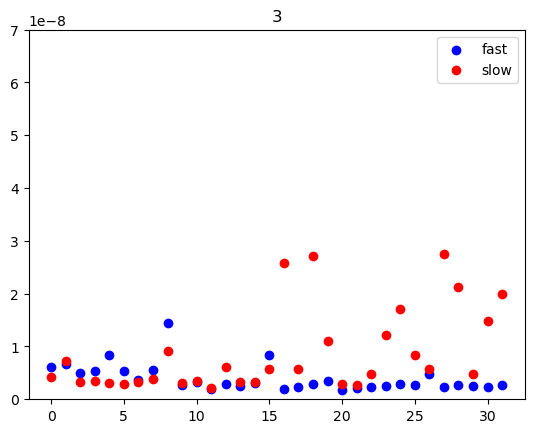

In [32]:
band = 3
fast, slow = bp_table[0,0,:,band], bp_table[0,1,:,band]

plt.scatter(range(len(fast)), fast, color='blue', label='fast')
plt.scatter(range(len(slow)), slow, color='red', label='slow')
plt.title(band)
plt.legend()
plt.ylim([0, 7e-8])
plt.show()


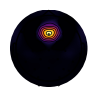

In [31]:
bp_subtracts = np.zeros((2, 32, 4))
bp_subtracts[0] = bp_table[1,:,:] - bp_table[0,:,:]
bp_subtracts[1] = bp_table[3,:,:] - bp_table[2,:,:]

raw = fe.channel_pos()
im, cn = mne.viz.plot_topomap(bp_subtracts[1,:,3], pos=raw.info, show=False, cmap="inferno", contours=6)

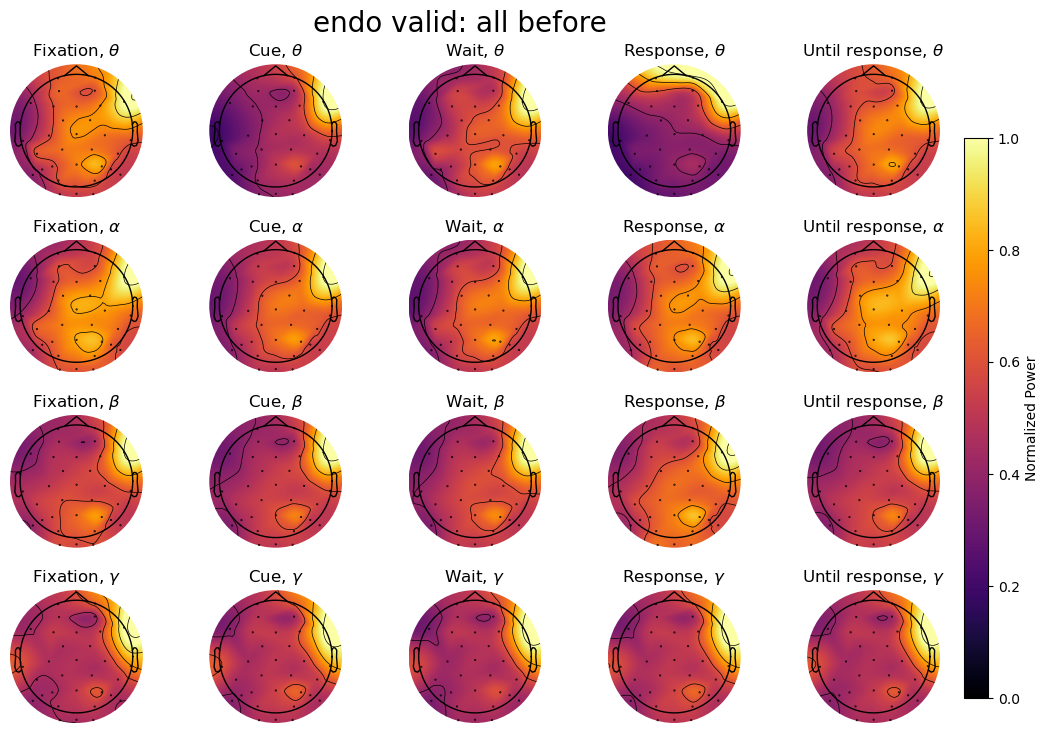

In [11]:
bp_topo = np.mean(bp_table, axis=0)
# bp_normed = np.zeros(bp_table.shape)
# for trial in range(bp_table.shape[0]):
#     for stage in range(bp_table.shape[2]):
#         for band in range(bp_table.shape[3]):
#             bp_normed[trial,:,stage,band] = bp_table[trial,:,stage,band]/np.max(bp_table[trial,:,stage,band])
# bp_topo = np.mean(bp_normed, axis=0)
stage_names = ['Fixation', 'Cue', 'Wait', 'Response', 'Until response']
band_names = ['$\u03B8$', '$\u03B1$', '$\u03B2$', '$\u03B3$']
raw = fe.channel_pos()

# Create a figure with the required grid size
fig, axes = plt.subplots(nrows=len(band_names), ncols=len(stage_names), figsize=(12, 8))

for j, stage in enumerate(stage_names):
    for k, band in enumerate(band_names):
        ax = axes[k, j]  # Get the correct axis from the grid
        norm_power = bp_topo[:, j, k] / np.max(bp_topo[:, j, k])
        im, cn = mne.viz.plot_topomap(norm_power, pos=raw.info, axes=ax, show=False, cmap="inferno", contours=4)
        # Add title to each subplot
        ax.set_title(stage + ', ' + band)

# Add a colorbar to the right of the subplots grid
cbar_ax = fig.add_axes([0.92, 0.15, 0.02, 0.7])
cbar = fig.colorbar(im, cax=cbar_ax, orientation='vertical')
cbar.set_label('Normalized Power')
fig.suptitle(case_title + ": all before", fontsize=20, y=1.01)
plt.subplots_adjust(wspace=0.5)  # you can adjust the value as needed
# plt.tight_layout()
plt.show()

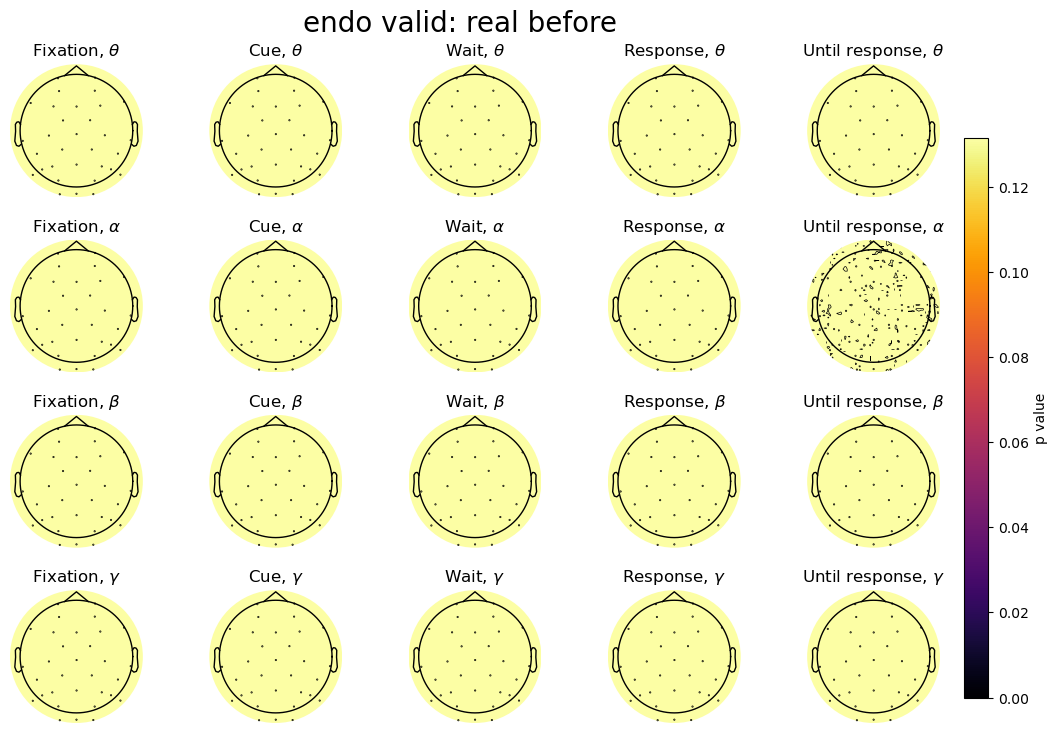

In [12]:
stage_names = ['Fixation', 'Cue', 'Wait', 'Response', 'Until response']
band_names = ['$\u03B8$', '$\u03B1$', '$\u03B2$', '$\u03B3$']
raw = fe.channel_pos()

# Create a figure with the required grid size
fig, axes = plt.subplots(nrows=len(band_names), ncols=len(stage_names), figsize=(12, 8))

for j, stage in enumerate(stage_names):
    for k, band in enumerate(band_names):
        ax = axes[k, j]  # Get the correct axis from the grid
        im, cn = mne.viz.plot_topomap(bp_pvalue[:,j,k], pos=raw.info, axes=ax, show=False, cmap="inferno", contours=7)
        # Add title to each subplot
        ax.set_title(stage + ', ' + band)

# Add a colorbar to the right of the subplots grid
cbar_ax = fig.add_axes([0.92, 0.15, 0.02, 0.7])
cbar = fig.colorbar(im, cax=cbar_ax, orientation='vertical')
cbar.set_label('p value')
fig.suptitle(case_title + ": real before", fontsize=20, y=1.01)
plt.subplots_adjust(wspace=0.5)  # you can adjust the value as needed
# plt.tight_layout()
plt.show()

In [13]:
# # mean trial: bp_table -> bp_topo: (trials, channels, stages, bands) -> (channels, stages, bands)
# bp_topo = np.mean(bp_table, axis=0)
# stage_names = ['Fixation', 'Cue', 'Wait', 'Response', 'Until response']
# band_names = ['$\u03B8$', '$\u03B1$', '$\u03B2$', '$\u03B3$']
# raw = fe.channel_pos()

# for j, stage in enumerate(stage_names):
#     for k, band in enumerate(band_names):
#         fig, ax = plt.subplots(figsize=(2.5, 1.1))
#         norm_power = bp_topo[:, j, k] / np.max(bp_topo[:, j, k])
#         im, cn = mne.viz.plot_topomap(norm_power, pos=raw.info, axes=ax, show=False, cmap="inferno", contours=7)
#         # Add title
#         ax.set_title(stage + ', ' + band)
#         # Add colorbar
#         cbar = plt.colorbar(im, ax=ax, orientation='vertical')
#         cbar.set_label('Normalized Power')  # Change this label to whatever is appropriate for your data
#         plt.show()